# Exercise: Vegetation change detection

## Set up notebook

### Load packages and functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map
from deafrica_tools.bandindices import calculate_indices

Note that we have imported one new function for this exercise in the cell above: ```calculate indices```.

### Connect to the datacube

We create a new connection to the Open Data Cube, and store it as the variable ```dc```.

In [2]:
dc = datacube.Datacube(app="Vegetation_exercise")

For this exercise, we will select our area of interest by picking a centre point and specifying a ```buffer``` of space (in degrees) on all sides of it.
We also create a variable called ```time_baseline``` which specifies a time in the middle of our date range which will be used to split the data into two groups later.

In [3]:
# Define the area of interest
latitude = 0.02
longitude = 35.425
buffer = 0.1

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2013-01-01', '2018-12-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2015-12-31'

We use the ```display_map``` function to visualize the extents which will be loaded.

In [4]:
display_map(x=lon_range, y=lat_range)

### Load data

In the following cell, we use the ```load_ard``` function to request data from the Open Data Cube, and we store it into the ```landsat_ds``` variable.  Loading the data will take a moment, but we should end up with 46 time steps.

In [5]:
landsat_ds = load_ard(
    dc=dc,
    products=["ls8_c2l2"],
    lat=lat_range,
    lon=lon_range,
    time=time,
    output_crs="EPSG:6933",
    resolution=(-30, 30),
    align=(15, 15),
    group_by='solar_day',
    measurements=['nir', 'red', 'blue'],
    min_gooddata=0.7)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 46 out of 213 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 46 time steps


## Calculate Indices

Below, we will use the ```calculate_indices``` function to add a new variable called ```EVI``` to our dataset, and we replace the original ```landsat_ds``` with our modified version.

In [6]:
landsat_ds = calculate_indices(landsat_ds, index='EVI', collection='c2')

## Detect Changes

Now we will use ```slice``` and ```sel``` to split our time series into two pieces and store the EVI data from each part into a variable:

- ```baseline_sample``` will contain data between the _first_ date in our ```time``` variable (```'2013-01-01'```) and the date we stored as ```time_baseline``` (```'2015-12-31'```)
- ```postbaseline_sample``` will contain data between the ```time_baseline``` and the _second_ date stored in our ```'time'``` variable (```'2018-12-01'```)

Remember that Python numbering starts at zero, so ```time[0]``` is the first entry, and ```time[1]``` is the second.

In [7]:
baseline_sample = landsat_ds.EVI.sel(time=slice(time[0], time_baseline))
postbaseline_sample = landsat_ds.EVI.sel(time=slice(time_baseline, time[1]))

### Detect per-pixel changes

First, we will use the ```mean``` function to find the average of all pixels in each of the new datasets along the time axis.

In [8]:
baseline_composite = baseline_sample.mean('time')
postbaseline_composite = postbaseline_sample.mean('time')

Next, we will calculate the difference between the two mean mosaics and store that as ```diff_mean_composites```.

In [9]:
diff_mean_composites = postbaseline_composite - baseline_composite

Finally, we plot the difference.

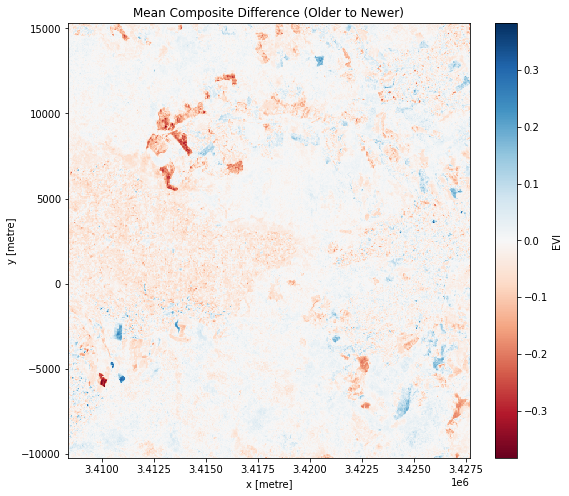

In [10]:
plt.figure(figsize=(9, 8))
diff_mean_composites.plot.imshow(cmap='RdBu')
plt.title("Mean Composite Difference (Older to Newer)")
plt.show()